In [1]:
#From https://github.com/PacktPublishing/Causal-Inference-and-Discovery-in-Python/blob/main/Chapter_13.ipynb

import os
os.environ['CASTLE_BACKEND'] = 'pytorch'

from collections import OrderedDict
import warnings

import numpy as np
import networkx as nx

from scipy import linalg 

from sklearn.linear_model import LinearRegression

import castle
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation 

from castle.algorithms import PC, GES
from castle.algorithms import ANMNonlinear, ICALiNGAM, DirectLiNGAM
from castle.algorithms import Notears, NotearsNonlinear, GOLEM

from castle.common.priori_knowledge import PrioriKnowledge

from castle.common.independence_tests import hsic_test

import matplotlib.pyplot as plt

from dowhy import gcm
import pandas as pd

2024-03-05 13:49:35,113 - /home/flav/anaconda3/lib/python3.11/site-packages/castle/algorithms/__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


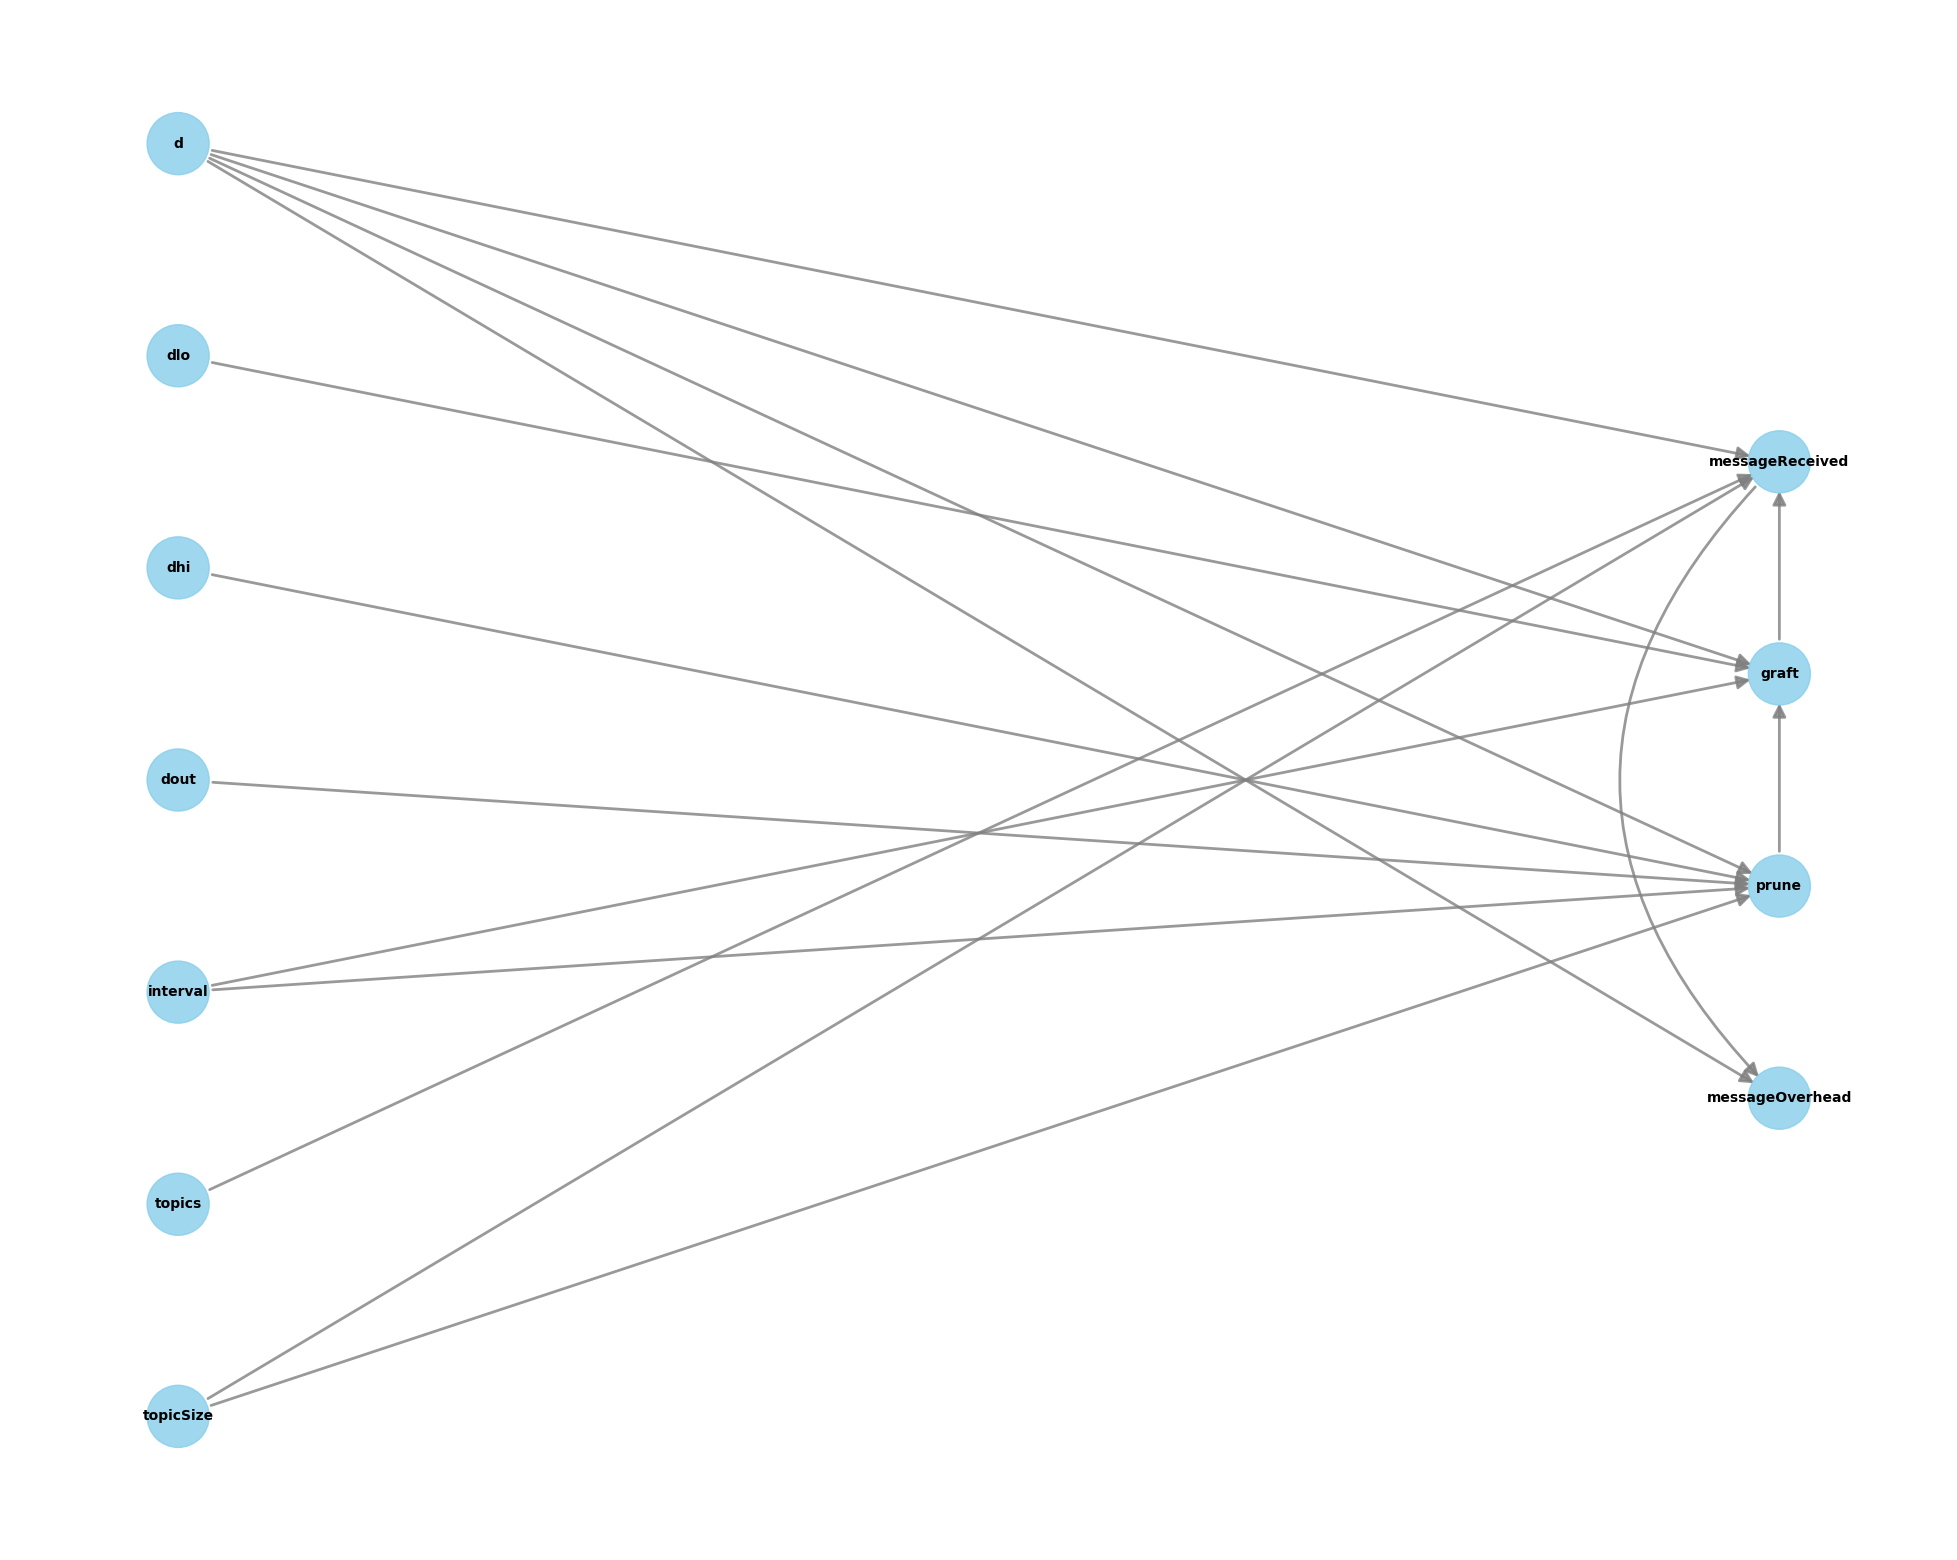

In [2]:
#Causal graph
causal_graph = nx.DiGraph([('d', 'messageReceived'),
                           ('d', 'graft'),
                           ('d', 'prune'),
                           ('dlo', 'graft'),
                           ('dhi', 'prune'),
                           ('dout', 'prune'),
                           ('interval', 'graft'),
                           ('interval', 'prune'),
                           ('prune', 'graft'),
                           ('messageReceived', 'messageOverhead'),
                           ('graft','messageReceived'),
                           ('topics', 'messageReceived'),
                           ('d', 'messageOverhead'),
                           ('topicSize', 'messageReceived'),
                           ('topicSize','prune'),
                         ])


G=gcm.util.plot(causal_graph, figure_size=[25, 20])
# nx.write_adjlist(H, "pc.adjlist")

In [3]:
#From digraph to adjancency matrix

# true_causal_matrix = nx.adjacency_matrix(causal_graph)
true_causal_matrix = nx.to_numpy_array(causal_graph)

print(true_causal_matrix)
print(causal_graph.nodes)

[[0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
['d', 'messageReceived', 'graft', 'prune', 'dlo', 'dhi', 'dout', 'interval', 'messageOverhead', 'topics', 'topicSize']


In [8]:
#Treat dataset

#Import data 
# data = pd.read_csv('../datasets/consolidated.csv',header=0, index_col=0)
data = pd.read_csv('../../../Datasets/Networkwise/consolidated_5s.csv',header=0, index_col=0)
consolidated = pd.DataFrame(data)


consolidated = consolidated.drop(columns=['experiment', 'topology'])#, 'messageBandwidth'])#, 'gossipBandwidth'])#, 'messageDuplicated'])#, 'n_nodes', 'consensus', 'messageDuplicated'])
# consolidated = consolidated.loc[consolidated['totalBandwidth'] > 0]
# consolidated.head(100)

consolidateddiff = consolidated.dropna().dropna()

X = consolidateddiff[['d', 'messageReceived', 'graft', 'prune', 'dlo', 'dhi', 'dout', 'interval', 'messageOverhead', 'topics', 'topicSize']].to_numpy()
consolidated = consolidateddiff[['d', 'messageReceived', 'graft', 'prune', 'dlo', 'dhi', 'dout', 'interval', 'messageOverhead', 'topics', 'topicSize']]

#Rearrange columns according to nodes list
# nodes = causal_graph.nodes

# X = consolidated[['d', 'messageReceived', 'graft', 'prune', 'iwant', 'dlo', 'dhi', 'dscore', 'dlazy', 'ihave', 'dout', 'gossipFactor', 'interval', 'messageOverhead']].to_numpy()

# X = consolidated.to_numpy()
# print(X)
consolidated.head(500)

,d,messageReceived,graft,prune,dlo,dhi,dout,interval,messageOverhead,topics,topicSize
0,8,43.0,0.0,0.0,6,12,2,1.0,321.0,1,16
1,8,54.0,0.0,0.0,6,12,2,1.0,389.0,1,16
2,8,96.0,0.0,0.0,6,12,2,1.0,702.0,1,16
3,8,88.0,0.0,0.0,6,12,2,1.0,629.0,1,16
4,8,61.0,0.0,0.0,6,12,2,1.0,454.0,1,16
...,...,...,...,...,...,...,...,...,...,...,...
495,16,18.0,0.0,0.0,8,20,4,0.5,62.0,1,16
496,16,56.0,0.0,0.0,8,20,4,0.5,250.0,1,16
497,16,50.0,0.0,0.0,8,20,4,0.5,175.0,1,16
498,16,58.0,0.0,0.0,8,20,4,0.5,239.0,1,16


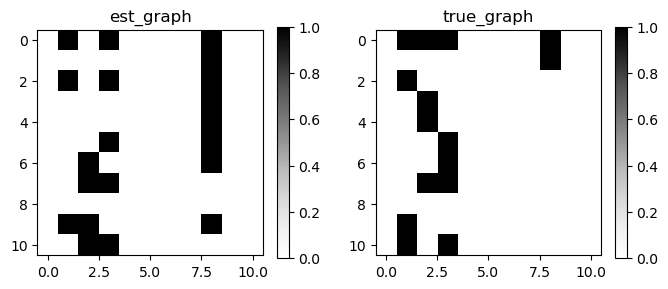

{'fdr': 0.5, 'tpr': 0.6667, 'fpr': 0.25, 'shd': 14, 'nnz': 20, 'precision': 0.5, 'recall': 0.6667, 'F1': 0.5714, 'gscore': 0.0}


In [16]:
# structure learning
priori = PrioriKnowledge(X.shape[1])
# priori.add_forbidden_edges([
# (0,0),	(0,4),	(0,5),	(0,6),	(0,7),	(0,9),(0,10),
# (1,0),	(1,4),	(1,5),	(1,6),	(1,7),	(1,9),(1,10),
# (2,0),	(2,3),  (2,4),	(2,5),	(2,6),  (2,9),(2,10),
# (3,0),	(3,4),	(3,5),	(3,6),	(3,7),	(3,9),(3,10),
# (4,0),	(4,4),	(4,5),	(4,6),	(4,7),	(4,9),(4,10),
# (5,0),	(5,4),	(5,5),	(5,6),	(5,7),	(5,9),(5,10),
# (6,0),	(6,4),	(6,5),	(6,6),	(6,7),	(6,9),(6,10),
# (7,0),	(7,4),	(7,5),	(7,6),	(7,7),	(7,9),(7,10),
# (8,0),	(8,1),  (8,4),	(8,5),	(8,6),	(8,7),(8,9),(8,10),
# (9,0),	(9,4),	(9,5),	(9,6),	(9,7),	(9,9),(9,10),
# (10,0), (10,4), (10,5), (10,6), (10,7), (10,9)
# ])

priori.add_forbidden_edges([
(0,0),	(0,4),	(0,5),	(0,6),	(0,7),	(0,9),(0,10),
(1,0),	(1,4),	(1,5),	(1,6),	(1,7),	(1,9),(1,10),
(2,0),	(2,4),  (2,5),	(2,6),	(2,7),  (2,9),(2,10),
(3,0),	(3,4),	(3,5),	(3,6),	(3,7),	(3,9),(3,10),
(4,0),	(4,4),	(4,5),	(4,6),	(4,7),	(4,9),(4,10),
(5,0),	(5,4),	(5,5),	(5,6),	(5,7),	(5,9),(5,10),
(6,0),	(6,4),	(6,5),	(6,6),	(6,7),	(6,9),(6,10),
(7,0),	(7,4),	(7,5),	(7,6),	(7,7),	(7,9),(7,10),
(8,0),  (8,4),	(8,5),	(8,6),	(8,7),  (8,9),(8,10),
(9,0),	(9,4),	(9,5),	(9,6),	(9,7),	(9,9),(9,10),
(10,0), (10,4), (10,5), (10,6), (10,7), (10,9)
])


# priori.add_required_edges([(1,8)]) 
                           # (18, 16),
                           # (6,2),
                           # (5,3)])
pc = PC(variant='original', priori_knowledge=priori)
pc.learn(X)

# plot predict_dag and true_dag
GraphDAG(pc.causal_matrix, true_causal_matrix, 'result')

# calculate metrics
mt = MetricsDAG(pc.causal_matrix, true_causal_matrix)
print(mt.metrics)

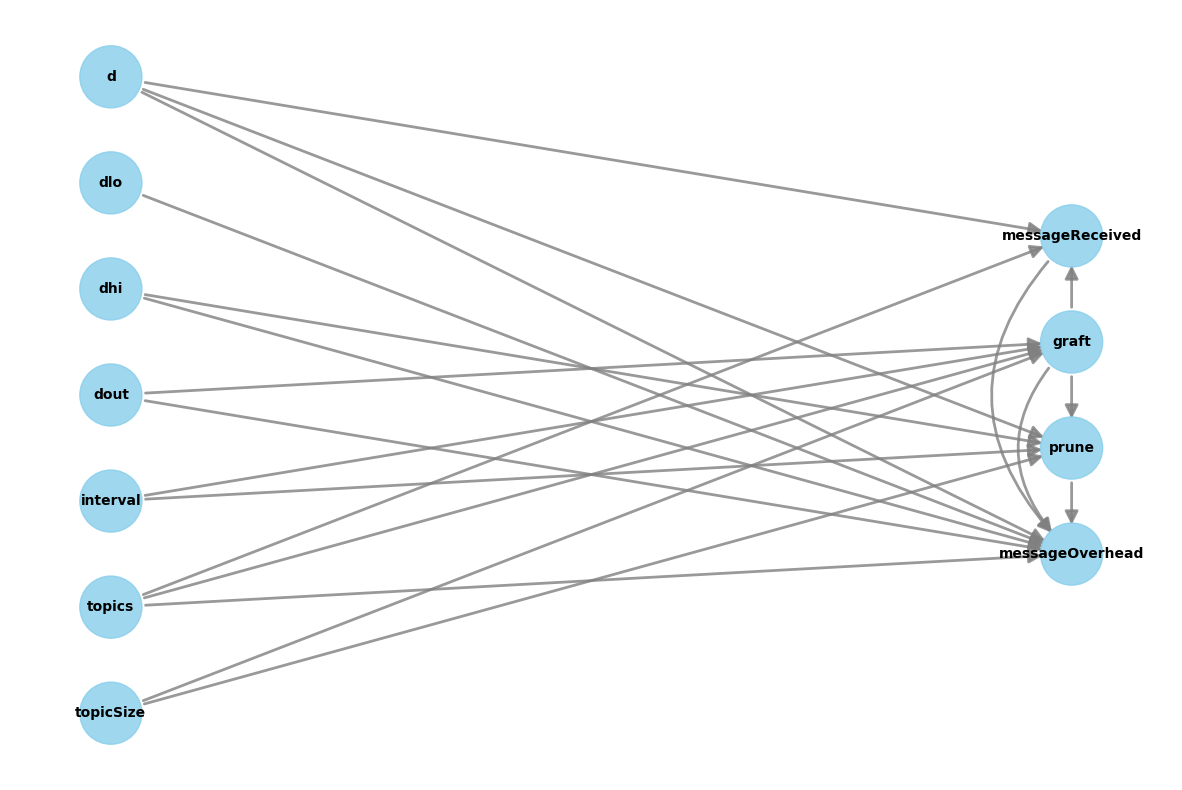

In [17]:
learned_causal_graph = nx.from_numpy_array(pc.causal_matrix, create_using=nx.DiGraph)

mapping = {0:'d',
            1:'messageReceived',
            2:'graft',
            3:'prune',
            4:'dlo',
            5:'dhi',
            6:'dout',
            7:'interval',
            8:'messageOverhead',
            9:'topics',
           10:'topicSize'
          }

# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

# fig, ax = plt.subplots(figsize=(30,30))

G=gcm.util.plot(H, figure_size=[15, 10])

nx.write_adjlist(H, "pc5s.adjlist")

# nx.draw(G)

# plt.savefig("PCNoPrioriKnowledge.png") # save as png
# plt.show() # displab

In [11]:
consolidateddiff = consolidated.diff().dropna().dropna()

X = consolidateddiff[['d', 'messageReceived', 'graft', 'prune', 'dlo', 'dhi', 'dout', 'interval', 'messageOverhead', 'topics', 'topicSize']].to_numpy()
consolidated = consolidateddiff[['d', 'messageReceived', 'graft', 'prune', 'dlo', 'dhi', 'dout', 'interval', 'messageOverhead', 'topics', 'topicSize']]

consolidated.head(500)

,d,messageReceived,graft,prune,dlo,dhi,dout,interval,messageOverhead,topics,topicSize
1,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0,0.0,0.0
2,0.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,313.0,0.0,0.0
3,0.0,-8.0,0.0,0.0,0.0,0.0,0.0,0.0,-73.0,0.0,0.0
4,0.0,-27.0,0.0,0.0,0.0,0.0,0.0,0.0,-175.0,0.0,0.0
5,0.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,232.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
496,0.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,188.0,0.0,0.0
497,0.0,-6.0,0.0,0.0,0.0,0.0,0.0,0.0,-75.0,0.0,0.0
498,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0
499,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0


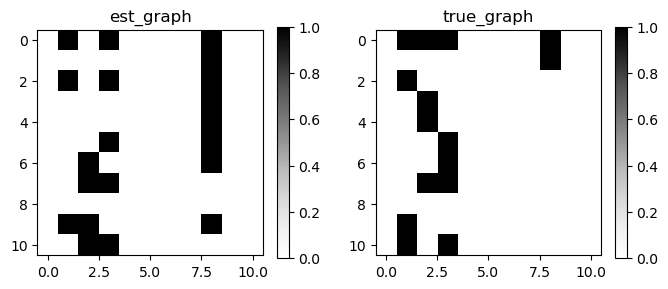

{'fdr': 0.5, 'tpr': 0.6667, 'fpr': 0.25, 'shd': 14, 'nnz': 20, 'precision': 0.5, 'recall': 0.6667, 'F1': 0.5714, 'gscore': 0.0}


In [19]:
# structure learning
priori = PrioriKnowledge(X.shape[1])
priori.add_forbidden_edges([
(0,0),	(0,4),	(0,5),	(0,6),	(0,7),	(0,9),(0,10),
(1,0),	(1,4),	(1,5),	(1,6),	(1,7),	(1,9),(1,10),
(2,0),	(2,4),  (2,5),	(2,6),	(2,7),  (2,9),(2,10),
(3,0),	(3,4),	(3,5),	(3,6),	(3,7),	(3,9),(3,10),
(4,0),	(4,4),	(4,5),	(4,6),	(4,7),	(4,9),(4,10),
(5,0),	(5,4),	(5,5),	(5,6),	(5,7),	(5,9),(5,10),
(6,0),	(6,4),	(6,5),	(6,6),	(6,7),	(6,9),(6,10),
(7,0),	(7,4),	(7,5),	(7,6),	(7,7),	(7,9),(7,10),
(8,0),  (8,4),	(8,5),	(8,6),	(8,7),  (8,9),(8,10),
(9,0),	(9,4),	(9,5),	(9,6),	(9,7),	(9,9),(9,10),
(10,0), (10,4), (10,5), (10,6), (10,7), (10,9)

])

# priori.add_required_edges([(1,8)]) 
                           # (18, 16),
                           # (6,2),
                           # (5,3)])
pc = PC(variant='original', priori_knowledge=priori)
pc.learn(X)

# plot predict_dag and true_dag
GraphDAG(pc.causal_matrix, true_causal_matrix, 'result')

# calculate metrics
mt = MetricsDAG(pc.causal_matrix, true_causal_matrix)
print(mt.metrics)

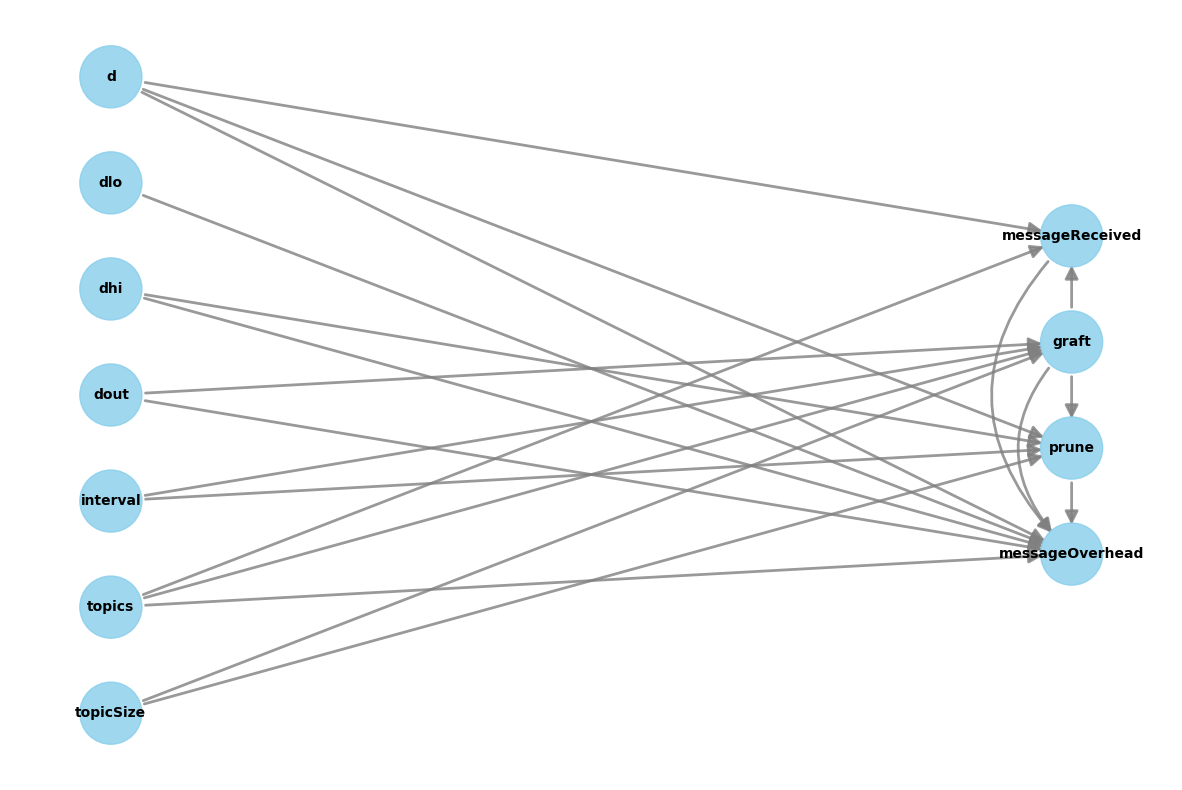

In [20]:
learned_causal_graph = nx.from_numpy_array(pc.causal_matrix, create_using=nx.DiGraph)

mapping = {0:'d',
            1:'messageReceived',
            2:'graft',
            3:'prune',
            4:'dlo',
            5:'dhi',
            6:'dout',
            7:'interval',
            8:'messageOverhead',
            9:'topics',
           10:'topicSize'
          }

# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

# fig, ax = plt.subplots(figsize=(30,30))

G=gcm.util.plot(H, figure_size=[15, 10])

nx.write_adjlist(H, "pcDiff5s.adjlist")

# nx.draw(G)

# plt.savefig("PCNoPrioriKnowledge.png") # save as png
# plt.show() # displab

In [24]:
consolidateddiff = np.log(consolidated).fillna(0)#consolidated.ln().dropna().dropna()

X = consolidateddiff[['d', 'messageReceived', 'graft', 'prune', 'dlo', 'dhi', 'dout', 'interval', 'messageOverhead', 'topics', 'topicSize']].to_numpy()
consolidated = consolidateddiff[['d', 'messageReceived', 'graft', 'prune', 'dlo', 'dhi', 'dout', 'interval', 'messageOverhead', 'topics', 'topicSize']]

consolidated.head(500)

/home/flav/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/flav/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


,d,messageReceived,graft,prune,dlo,dhi,dout,interval,messageOverhead,topics,topicSize
1,0.0,0.874591,0.0,0.0,0.0,0.0,0.0,0.0,1.439718,0.0,0.0
2,0.0,1.318462,0.0,0.0,0.0,0.0,0.0,0.0,1.748539,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5,0.0,1.268453,0.0,0.0,0.0,0.0,0.0,0.0,1.695017,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
496,0.0,1.291320,0.0,0.0,0.0,0.0,0.0,0.0,1.655642,0.0,0.0
497,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
498,0.0,0.732099,0.0,0.0,0.0,0.0,0.0,0.0,1.425247,0.0,0.0
499,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.079918,0.0,0.0


/home/flav/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2699: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


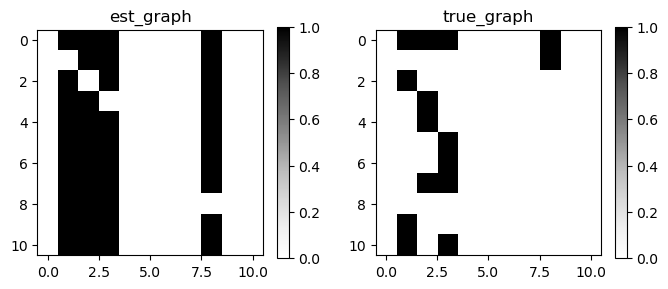

{'fdr': 0.5588, 'tpr': 1.0, 'fpr': 0.475, 'shd': 19, 'nnz': 34, 'precision': 0.375, 'recall': 1.0, 'F1': 0.5455, 'gscore': 0.0}


In [25]:
# structure learning
priori = PrioriKnowledge(X.shape[1])
priori.add_forbidden_edges([
(0,0),	(0,4),	(0,5),	(0,6),	(0,7),	(0,9),(0,10),
(1,0),	(1,4),	(1,5),	(1,6),	(1,7),	(1,9),(1,10),
(2,0),	(2,4),  (2,5),	(2,6),	(2,7),  (2,9),(2,10),
(3,0),	(3,4),	(3,5),	(3,6),	(3,7),	(3,9),(3,10),
(4,0),	(4,4),	(4,5),	(4,6),	(4,7),	(4,9),(4,10),
(5,0),	(5,4),	(5,5),	(5,6),	(5,7),	(5,9),(5,10),
(6,0),	(6,4),	(6,5),	(6,6),	(6,7),	(6,9),(6,10),
(7,0),	(7,4),	(7,5),	(7,6),	(7,7),	(7,9),(7,10),
(8,0),  (8,4),	(8,5),	(8,6),	(8,7),  (8,9),(8,10),
(9,0),	(9,4),	(9,5),	(9,6),	(9,7),	(9,9),(9,10),
(10,0), (10,4), (10,5), (10,6), (10,7), (10,9)

])

# priori.add_required_edges([(1,8)]) 
                           # (18, 16),
                           # (6,2),
                           # (5,3)])
pc = PC(variant='original', priori_knowledge=priori)
pc.learn(X)

# plot predict_dag and true_dag
GraphDAG(pc.causal_matrix, true_causal_matrix, 'result')

# calculate metrics
mt = MetricsDAG(pc.causal_matrix, true_causal_matrix)
print(mt.metrics)

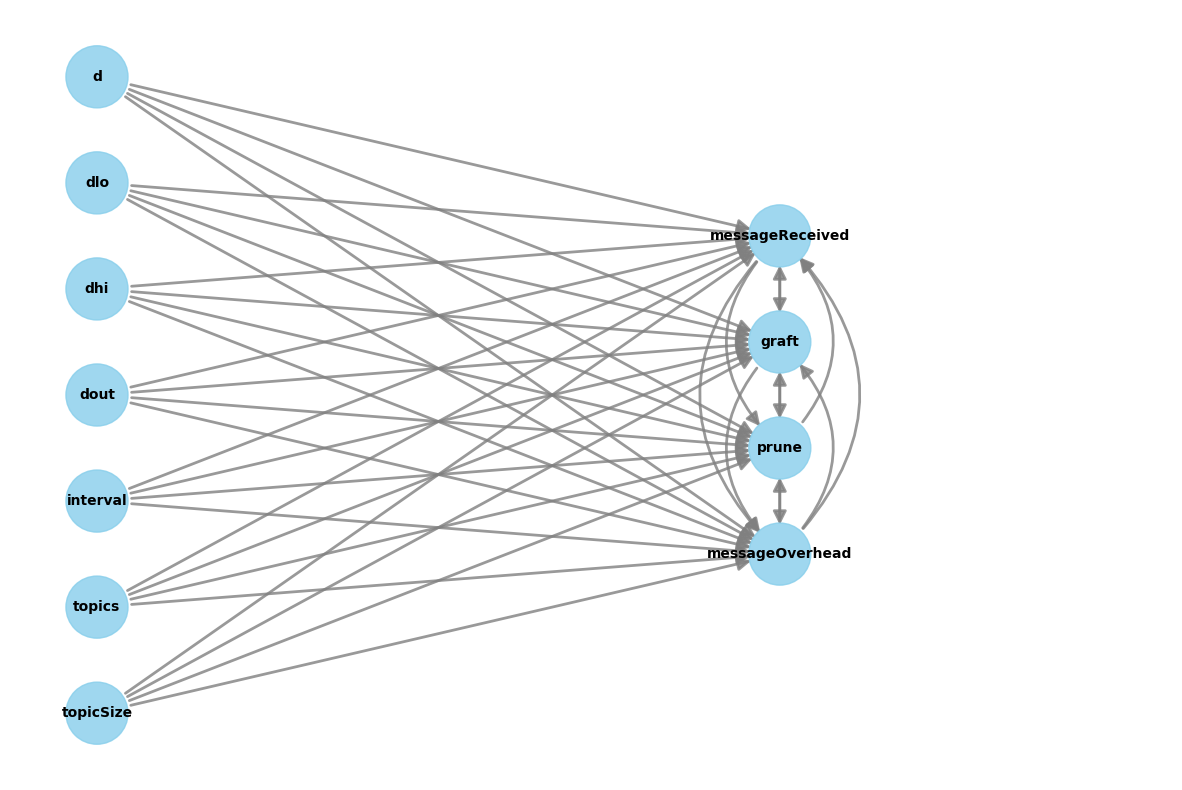

In [26]:
learned_causal_graph = nx.from_numpy_array(pc.causal_matrix, create_using=nx.DiGraph)

mapping = {0:'d',
            1:'messageReceived',
            2:'graft',
            3:'prune',
            4:'dlo',
            5:'dhi',
            6:'dout',
            7:'interval',
            8:'messageOverhead',
            9:'topics',
           10:'topicSize'
          }

# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

# fig, ax = plt.subplots(figsize=(30,30))

G=gcm.util.plot(H, figure_size=[15, 10])

nx.write_adjlist(H, "pcLog5s.adjlist")

# nx.draw(G)

# plt.savefig("PCNoPrioriKnowledge.png") # save as png
# plt.show() # displab